# Get GradCAM image for an object using VGG network.

**Objective:** Get the GradCAM ( Gradient weighted Class Activation Map) for the **Sunglasses** object in the **imagenet dataset** using VGG network.

## Get Pretrained VGG Model

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import keras.backend as K

Using TensorFlow backend.


In [2]:
model = VGG16(weights="imagenet")





553467904/553467096 [==============================] - 43s 0us/step




In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

To generate GradCAM images, we are interested in the following layers: **block5_conv3, block5_conv2, block5_conv1**.

## Load the input image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
#!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg


--2019-09-18 09:54:03--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.245.83, 190.93.244.83, 190.93.247.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.245.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.003s  

2019-09-18 09:54:03 (16.1 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’ saved [58670/58670]



In [0]:
!cp '/content/drive/My Drive/App/EVA/Session10/person.png' /content

In [0]:
from skimage import io
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
##url = "https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg"

#input_img = io.imread(url)

#dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
#cv2_imshow(dog)

In [0]:
input_img = io.imread('/content/person.png')
#plt.imshow(input_img)

In [8]:
input_img.shape

(692, 695, 3)

## Prepare the image for VGG

In [0]:
img = cv2.resize(input_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(img)  #keras.processing image util
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [11]:
x.shape

(1, 224, 224, 3)

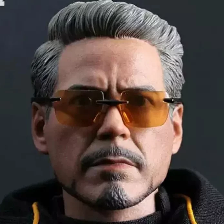

In [14]:
## for open cv, we have to covert color to BGR format
cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#cv2_imshow(img)

## Get ImageNet Class Names

[Refer to this github location for Imagenet Labels:](https://github.com/anishathalye/imagenet-simple-labels/blob/master/imagenet-simple-labels.json) 

In [16]:
##!wget https://github.com/anishathalye/imagenet-simple-labels/blob/master/imagenet-simple-labels.json

## get the raw file
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

--2019-09-18 09:54:53--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14176 (14K) [text/plain]
Saving to: ‘imagenet-simple-labels.json’

imagenet-simple-lab 100%[===================>]  13.84K  --.-KB/s    in 0.01s   

2019-09-18 09:54:53 (1.08 MB/s) - ‘imagenet-simple-labels.json’ saved [14176/14176]



In [0]:
import json

json_file = '/content/imagenet-simple-labels.json'
with open(json_file) as f:
    labels = json.load(f)

def class_id_to_label(i):
    return labels[i]

## Predict

[Image net : labels are avialble here](http://image-net.org/challenges/LSVRC/2012/browse-synsets)

In [18]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)

837


In [19]:
print(class_id_to_label(837))

sunglasses


## Get GradCAM for layer block5_conv2

### Get Class Activation Maps and Compute Gradients

In [0]:
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv2")

In [59]:
print(class_output)
print(last_conv_layer)

Tensor("strided_slice_11:0", shape=(?,), dtype=float32)


In [60]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)




1.   Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
2.   Normalize the heat map to make the values between 0 and 1


In [61]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the GradCAM image

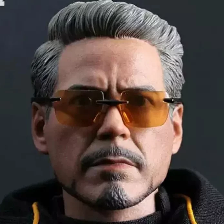

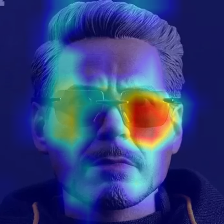

In [62]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)
 
## display
cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2_imshow(superimposed_img)

In [63]:
cv2.imwrite('/content/block5_conv2_out.png', superimposed_img)

True

## Get GradCAM for layer block5_conv1

In [0]:
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv1")

In [65]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [66]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


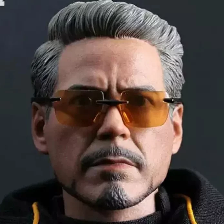

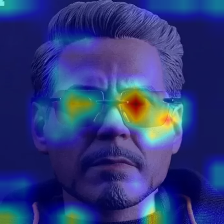

In [67]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)
 
## display
cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2_imshow(superimposed_img)

In [68]:
cv2.imwrite('/content/block5_conv1_out.png', superimposed_img)

True

## Get GradCAM for layer block5_conv3 (close to prediction layer)

In [0]:
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

In [70]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [71]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


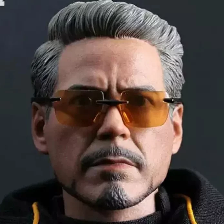

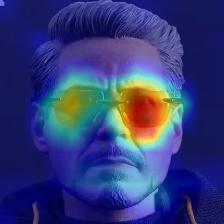

In [72]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)
 
## display
cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2_imshow(superimposed_img)

In [73]:
cv2.imwrite('/content/block5_conv3_out.png', superimposed_img)

True